## Part 3 - Cluster 2: Network Manipulation

### <b>Task</b> : Dynamic Network Analysis

## 1. Dynamic Network creation: modellazione *Snapshot Graphs*

### 1.1 Settings/Data Preprocessing:
In our construction of the Dynamic Network, 4 Snapshot Graphs are generated, used to represent weekly Snapshots of the graph, and analysed over the observed period which is December 2022 

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import dynetx as dn
import enum
import dynetx.algorithms as al

import sys
sys.path.append('..')
from utils import *

df = pd.read_csv('../reddit_comments.csv', index_col = False) #con ../ metti direttamente il file
df['parent_id'] = df['parent_id'].str.slice(3)

author = 'author' #id
parent_author = 'parent_author' #id padre del commento

df_edges_date = df[['date',parent_author,author]]
df_edges_date = df_edges_date.sort_values('date')
df_edges_date = df_edges_date.reset_index(drop=True)

date_tempi_t = df_edges_date['date'].unique()
date_tempi_t
#df_edges_date.to_csv('../df_edges_date.csv')

array(['02/12/2022', '03/12/2022', '04/12/2022', '05/12/2022',
       '06/12/2022', '07/12/2022', '08/12/2022', '09/12/2022',
       '10/12/2022', '11/12/2022', '12/12/2022', '13/12/2022',
       '14/12/2022', '15/12/2022', '16/12/2022', '17/12/2022',
       '18/12/2022', '19/12/2022', '20/12/2022', '21/12/2022',
       '22/12/2022', '23/12/2022', '24/12/2022', '25/12/2022',
       '26/12/2022', '27/12/2022', '28/12/2022', '29/12/2022',
       '30/12/2022', '31/12/2022'], dtype=object)

In [2]:
totale_date_t = len(date_tempi_t)
print("Gli intervalli di tempo/date totali presenti nel dataset sono: " + str(totale_date_t))

Gli intervalli di tempo/date totali presenti nel dataset sono: 30


### In quanti snapshot temporali vogliamo suddividere la Dynamic Network ?

Settaggio della variabile: ``size_finestra_t``

In [3]:
size_finestra_t = 7
max_class_t = int(totale_date_t/7) #totale classi di tempo_t

print("Totale delle classi/gruppi temporali di suddivisione degli Snapshot\nottenuti in base alla finestra di valore:",size_finestra_t,"\nè: ",max_class_t)

Totale delle classi/gruppi temporali di suddivisione degli Snapshot
ottenuti in base alla finestra di valore: 7 
è:  4


### Associazione delle date ad una classe/gruppo di tempo *t*

In [4]:
# Creiamo un dizionario per mappare le date ai valori numerici
mappa_valori = {}
map_value_classe_t = 0
count_giorni = 0

for data in date_tempi_t:
    if data not in mappa_valori:
        #giorno = estrai_giorno(data=data)
        #map_value_classe_t = get_classe_t_giorno(giorno=giorno)
        mappa_valori[data] = map_value_classe_t
        count_giorni += 1

        if count_giorni >= size_finestra_t: #se si arriva all'ottavo giorno, allora cambi 'finestra'
            if(map_value_classe_t+1) < max_class_t: # se si arriva alle ultime date, ovvero ultima classe 't' allora sarà sempre quella di default per le date restanti
                map_value_classe_t += 1 #altrimenti incrementa/si cambia classe 'tempo t' 
            count_giorni = 0 #e si riconta dinuovo


print(mappa_valori.values())

dict_values([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])


In [5]:
# Aggiungere una colonna con i valori numerici associati alle date
df_edges_date['Tempo t'] = df_edges_date['date'].map(mappa_valori)
df_edges_date

,date,parent_author,author,Tempo t
0,02/12/2022,AlAv812,Sajun,0
1,02/12/2022,InSearchOfUpdog,922153,0
2,02/12/2022,AlAv812,squareOfTwo,0
3,02/12/2022,922153,InSearchOfUpdog,0
4,02/12/2022,hi_there_bitch,doddiiin,0
...,...,...,...,...
49881,31/12/2022,mikkolukas,BaconSky,3
49882,31/12/2022,No_Ninja3309_NoNoYes,hezwat,3
49883,31/12/2022,jlangager,BaconSky,3
49884,31/12/2022,bungayjonathan,hezwat,3


Let's see which dates correspond to which instants of time *t*

In [6]:
df_valori_unici_date_t = df_edges_date[['date','Tempo t']].drop_duplicates()
df_valori_unici_date_t.head(10)

,date,Tempo t
0,02/12/2022,0
13,03/12/2022,0
91,04/12/2022,0
392,05/12/2022,0
831,06/12/2022,0
1510,07/12/2022,0
2904,08/12/2022,0
4524,09/12/2022,1
6314,10/12/2022,1
8066,11/12/2022,1


For our analysis we will take ``max_class_t`` timestamps of the graph calculated from the ``size_window_t`` we gave as input

## 1.2 Building the Dynamic Graph

In [9]:
nodes = pd.read_csv('../nodes.csv', index_col=False) #i nodi sono fixed, gli archi cambiano nel tempo

edges = df_edges_date 

#CREAZIONE GRAFO DINAMICO
dg = dn.DynGraph(edge_removal=False)

#Creo 't' sottografi che corrispondono agli snapshot
#i timestamp successivi coinvolgono anche i tempi precedenti

for t in range(0,max_class_t):
    G = nx.Graph()
    df = pd.DataFrame()

    condizione = df_edges_date['Tempo t'] <= t
    df = df_edges_date.loc[condizione]  # DataFrame  i soli dati al tempo 't'

    #creo edges
    edges = df.dropna(axis=0)
    
    #creo grafo
    G = nx.from_pandas_edgelist(edges, source = parent_author, target = author, create_using = nx.Graph())
    G.add_nodes_from(nodes)

    dg.add_interactions_from(G.edges(), t=t)

dg

## 2. Dynamic Network Analysis:
Analysis of *the built temporal(snapshot) graph* and *study of its stability*.


### 2.1 Snapshot Analysis:
We have the list of snapshot ids with, that corresponds 'max_class_time' i.e. the window of timestamp that we decided before

In [10]:
dg.temporal_snapshots_ids()

[0, 1, 2, 3]

Snapshot ids allow access to it.

Here we can see as the Snapshots increase, and thus as the network evolves, that they reach the maximum number of nodes and arcs reported in the Dynamic Graph.

The latter, we note, are 1/4 fewer than the original due to the evident repeated existence of these in each Snapshot.

In [11]:
for t in range(0,max_class_t):
    g1 = dg.time_slice(t)
    print("Snapshot "+str(t)+" = "+"Number of Nodes:", g1.number_of_nodes(),"; Number of Edges:",g1.number_of_edges())

#print(dg.number_of_nodes(), dg.number_of_edges())
print(dg)


Snapshot 0 = Number of Nodes: 1798 ; Number of Edges: 3186
Snapshot 1 = Number of Nodes: 6250 ; Number of Edges: 13449
Snapshot 2 = Number of Nodes: 9838 ; Number of Edges: 23317
Snapshot 3 = Number of Nodes: 13170 ; Number of Edges: 33741
DynGraph with 13170 nodes and 33741 edges


Following the same reasoning, it is possible to obtain timeslices covering a certain time window.

In the following example, the time window from 0 to 2 is observed;

In [12]:
g0_2 = dg.time_slice(t_from=0, t_to=2)

print("Numero nodi nell'intervallo:",g0_2.number_of_nodes(), "\nNumero edges nell'intervallo:",g0_2.number_of_edges(),"\nInterazioni Per Snapshot:",g0_2.interactions_per_snapshots())

Numero nodi nell'intervallo: 9838 
Numero edges nell'intervallo: 23317 
Interazioni Per Snapshot: {0: 1631.0, 1: 6855.5}


0: interactions in the first week observed. <br>
1: are the remaining interactions, where it is counted if the arc **remains** from the initial week to the next week(s) that are observed

### 2.2 - Dynamic network measures

The 'stream_interactions' method allows us to list the interaction stream in the DynGraph between nodes.
These are represented by is a 4-tuple (u, v, op, t), where:

- u, v are nodes
- op is an edge creation or deletion event (respectively +, -)
- t is the interactions timestamp

In [13]:
flag = True #se True stampa solo 'times' volte, else print all values
times = 5
count = 0
for i, e in enumerate(dg.stream_interactions()):
    print(e)
    count += 1
    if flag == True:
        if count == times:
            break


('AlAv812', 'Sajun', '+', 0)
('AlAv812', 'squareOfTwo', '+', 0)
('AlAv812', 'fastinguy11', '+', 0)
('AlAv812', 'l-L-li', '+', 0)
('AlAv812', 'InitialCreature', '+', 0)


#### Inter event time (Global)

How much time before a new interaction appears in the graph

In [14]:
r = dg.inter_event_time_distribution()
print(f"Number interactions Global: temporal distance\t{r}")

Number interactions Global: temporal distance	{0: 34278, 1: 3}


#### Inter event time (w.r.t. Specific random Node)
How much time before a new interaction ***involving a specific node*** appears in the graph

In [15]:
#u = extract_random_node(df_edges_date,column_name=parent_author)
#v = extract_random_node(df_edges_date,column_name=author)

u = 'Sajun'
v = 'AdolinKholin1'

In [16]:
r = dg.inter_event_time_distribution(u)
print(f"Number interactions: temporal distance\t{r}")

Number interactions: temporal distance	{0: 2, 2: 1}


#### Inter event time (w.r.t. Specific random Edge)

How long before a new interaction between two randomly taken nodes, u and v, appears in the graph

In [17]:
r = dg.inter_event_time_distribution(u, v)
print(f"Number interactions: temporal distance\t{r}")

Number interactions: temporal distance	{3: 1}


### Degree
Degrees can be queried time-wise, here we report the degree of a random node in each timestamp of the snapshot graph

In [18]:
for t in range(0,max_class_t):
    print("Degree of node at time t = ",t," : ",dg.degree(t=t)[u]) # degree of node 0 at time t=2

Degree of node at time t =  0  :  3
Degree of node at time t =  1  :  3
Degree of node at time t =  2  :  4
Degree of node at time t =  3  :  4


### Coverage

The ratio of existing nodes w.r.t. the possible ones.

In [19]:
dg.coverage()

0.5895216400911162

#### Node contribution and Edge contribution

Values of the node 'u' coverage and of edge (u, v) coverage of the temporal graph.

In [20]:
print("Node contribution:",dg.node_contribution(u),"\nEdge contribution:",dg.edge_contribution(u, v))

Node contribution: 1.0 
Edge contribution: 1.0


#### Node pair uniformity

Overlap between the presence times of u and v.

In [21]:
#u = extract_random_node(df_edges_date,column_name=parent_author)
#v = extract_random_node(df_edges_date,column_name=author)

dg.node_pair_uniformity(u, v)

1.0

### Density
Temporal network density: fraction of possible interactions that do exist in the temporal network.

In [22]:
dg.density()

0.0004634505016892961

#### Node Density
Intersection among the temporal presence of the node and the joint temporal presences of u.

In [23]:
dg.node_density(u)

0.00045079855744461616

#### Pair Density

Intersection among the temporal presence of the edge (u, v) and the joint temporal presences of u and v.

In [24]:
dg.pair_density(u, v)

1.0

#### Snapshot Density

Density of a temporal network at time t.

In [25]:
for t in dg.temporal_snapshots_ids():
    print("Density of graph at snapshot",f"{t}\t{dg.snapshot_density(t)}")

Density of graph at snapshot 0	0.001972141184510335
Density of graph at snapshot 1	0.0006886989918386941
Density of graph at snapshot 2	0.0004818736500712787
Density of graph at snapshot 3	0.00038908937622022865


### Path analysis

Computes the time respecting paths among u and v within [start, stop]

In [26]:
paths = al.time_respecting_paths(dg, u, v, start=0, end=3)

In [27]:
key = (u, v)
p = paths[key]
n_path_stampa = 4
count = 0

#(nodo partenza, nodo, passo 0),....,(nodo,nodo arrivo, passo N)
#passo 0 sarebbe il primo arco

# Stampa dei dati del dizionario
for key, value in paths.items():
    print(f"Chiave/Nodi (u,v): {key}")
    print("Dati:")
    for path in value:
        print("\n  - Percorso:")
        for node_pair in path:
            print(f"    - Nodi: {node_pair[0]} -> {node_pair[1]}, Distanza: {node_pair[2]}")
        # Incrementa il contatore
        count += 1
        # Interrompi il ciclo dopo i primi tre percorsi
        if count == n_path_stampa:
            break
    print("\n\n")
    # Interrompi il ciclo dopo i primi tre percorsi
    if count == n_path_stampa:
        break


Chiave/Nodi (u,v): ('Sajun', 'AdolinKholin1')
Dati:

  - Percorso:
    - Nodi: Sajun -> AdolinKholin1, Distanza: 0

  - Percorso:
    - Nodi: Sajun -> AdolinKholin1, Distanza: 0
    - Nodi: AdolinKholin1 -> AdolinKholin1, Distanza: 1

  - Percorso:
    - Nodi: Sajun -> InSearchOfUpdog, Distanza: 0
    - Nodi: InSearchOfUpdog -> AdolinKholin1, Distanza: 1

  - Percorso:
    - Nodi: Sajun -> AlAv812, Distanza: 0
    - Nodi: AlAv812 -> PC-Bjorn, Distanza: 1
    - Nodi: PC-Bjorn -> AdolinKholin1, Distanza: 2





We can compute length and duration of a given path, in our example we pick the second one extracted

In [28]:
extracted_path = p[3]
print("Path:",extracted_path)

print("Path duration:",al.path_duration(extracted_path), "Path lenght",al.path_length(extracted_path))

Path: (('Sajun', 'AlAv812', 0), ('AlAv812', 'PC-Bjorn', 1), ('PC-Bjorn', 'AdolinKholin1', 2))
Path duration: 2 Path lenght 3


### 2.3 Stability Study

For the study of stability, we chose to analyse the following metrics:  

### Jaccard Similarity Coefficient
Jaccard coefficient calculated on the edges between two consecutive snapshots

In [29]:
for t in range(max_class_t-1):  # dobbiamo escludere l'ultimo timestamp perché non ha un successivo
    g_t = dg.time_slice(t, t)
    g_t_plus_1 = dg.time_slice(t+1, t+1)
    
    edges_t = set(g_t.edges())
    edges_t_plus_1 = set(g_t_plus_1.edges())
    
    jaccard_coeff = len(edges_t & edges_t_plus_1) / len(edges_t | edges_t_plus_1)
    print(f"Jaccard coefficient between t={t} and t={t+1}: {jaccard_coeff}")
 
print()   

Jaccard coefficient between t=0 and t=1: 0.22187027571809084
Jaccard coefficient between t=1 and t=2: 0.5507726726602312
Jaccard coefficient between t=2 and t=3: 0.6671073810071281



### Clustering Coefficient:

In [30]:
for t in range(0,max_class_t):
    snap_t_flat_graph = dg.time_slice(t)
    print("Avg clustering coefficient Snapshot "+str(t)+" = ",nx.average_clustering(snap_t_flat_graph))

Avg clustering coefficient Snapshot 0 =  0.05685388318855746
Avg clustering coefficient Snapshot 1 =  0.05155528840522106
Avg clustering coefficient Snapshot 2 =  0.04596825507073335
Avg clustering coefficient Snapshot 3 =  0.043429197483374246


### Degree centrality : <br>
We analyze the degree centrality of each snapshot, also here we can observe that the best one in each snapshot it's the same node that we have in the network analysis

In [31]:
for t in range(0,max_class_t):
    snap_t = dg.time_slice(t)
    snap_t_flat_graph = nx.Graph(snap_t.edges())
    dict = nx.degree_centrality(snap_t_flat_graph)
    dict = sorted(dict.items(), key=lambda x: x[1], reverse=True) #ordina dizionario
    

    flag = True #se True stampa solo 'times' volte, else print all values
    times = 5
    count = 0
    for chiave, valore in dict:
        print("Degree Centrality of Snapshot "+str(t)+":",chiave,"{:.2f}".format(valore))
        count += 1
        if flag == True:
            if count == times:
                break
    print()

Degree Centrality of Snapshot 0: hi_there_bitch 0.09
Degree Centrality of Snapshot 0: InSearchOfUpdog 0.05
Degree Centrality of Snapshot 0: cristiano-potato 0.04
Degree Centrality of Snapshot 0: frequenttimetraveler 0.03
Degree Centrality of Snapshot 0: drekmonger 0.03

Degree Centrality of Snapshot 1: hi_there_bitch 0.11
Degree Centrality of Snapshot 1: perturbaitor 0.03
Degree Centrality of Snapshot 1: kamus10 0.03
Degree Centrality of Snapshot 1: TerrySharpHY 0.02
Degree Centrality of Snapshot 1: drekmonger 0.02

Degree Centrality of Snapshot 2: hi_there_bitch 0.08
Degree Centrality of Snapshot 2: TerrySharpHY 0.03
Degree Centrality of Snapshot 2: perturbaitor 0.02
Degree Centrality of Snapshot 2: TwoCoresOneThread 0.02
Degree Centrality of Snapshot 2: antigonemerlin 0.02

Degree Centrality of Snapshot 3: hi_there_bitch 0.07
Degree Centrality of Snapshot 3: TerrySharpHY 0.02
Degree Centrality of Snapshot 3: TwoCoresOneThread 0.02
Degree Centrality of Snapshot 3: perturbaitor 0.02
De

### Degrees and Degree Distribution:
We analyze the degree distribution for the Snapshot Graphs

In [32]:
# Calcola l'istogramma dei gradi
hist = []

for t in range(0,max_class_t):
    snap_t = dg.time_slice(t)
    snap_t_flat_graph = nx.Graph(snap_t.edges())
    hist.append(nx.degree_histogram(snap_t_flat_graph))

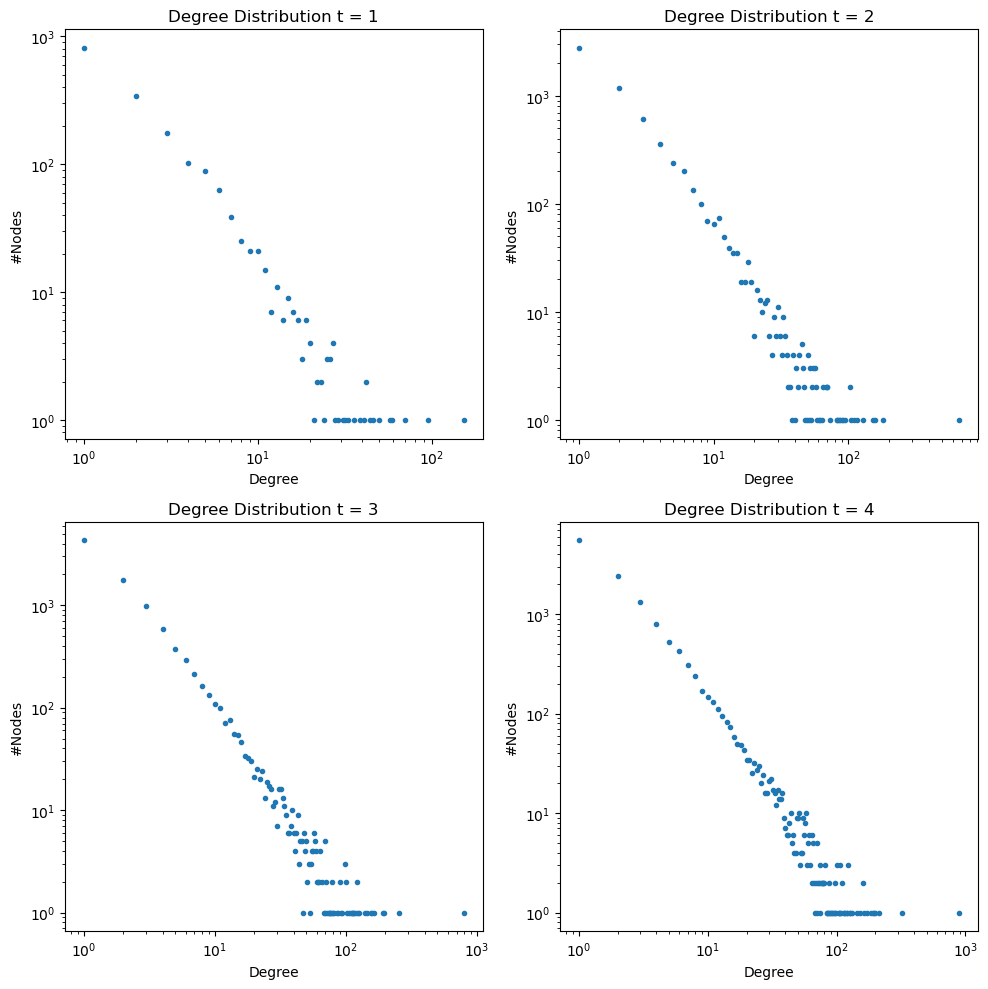

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].plot(range(0, len(hist[0])), hist[0], ".")
axes[0, 0].set_title("Degree Distribution t = 1")
axes[0, 0].set_xlabel("Degree")
axes[0, 0].set_ylabel("#Nodes")
axes[0, 0].loglog()

axes[0, 1].plot(range(0, len(hist[1])), hist[1], ".")
axes[0, 1].set_title("Degree Distribution t = 2")
axes[0, 1].set_xlabel("Degree")
axes[0, 1].set_ylabel("#Nodes")
axes[0, 1].loglog()

axes[1, 0].plot(range(0, len(hist[2])), hist[2], ".")
axes[1, 0].set_title("Degree Distribution t = 3")
axes[1, 0].set_xlabel("Degree")
axes[1, 0].set_ylabel("#Nodes")
axes[1, 0].loglog()

axes[1, 1].plot(range(0, len(hist[3])), hist[3], ".")
axes[1, 1].set_title("Degree Distribution t = 4")
axes[1, 1].set_xlabel("Degree")
axes[1, 1].set_ylabel("#Nodes")
axes[1, 1].loglog()


plt.tight_layout()
plt.show()

As we can see, there are few changes in density taking into account a total time window of one month, but these indicate the networks are evolving over time, growing slowly.